# inference mode

In [1]:
import numpy as np
import glob
import PIL
import cv2
import sys ,os
import matplotlib.pyplot as plt
%matplotlib inline
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import tensorflow as tf
import keras

/home/sdc/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
log_dir = '/home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/log7/'
sys.path.append('/home/sdc/github/AdversarialVariationalBayes/')

In [3]:
ls /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/log7/

checkpoint
events.out.tfevents.1510213298.frankwang-Tri01
events.out.tfevents.1510308286.frankwang-Tri01
events.out.tfevents.1510410881.frankwang-Tri01
events.out.tfevents.1510538807.frankwang-Tri01
events.out.tfevents.1510655368.frankwang-Tri01
events.out.tfevents.1510655931.frankwang-Tri01
graph.pbtxt
model.ckpt-1010272.data-00000-of-00001
model.ckpt-1010272.index
model.ckpt-1010272.meta
model.ckpt-1011707.data-00000-of-00001
model.ckpt-1011707.index
model.ckpt-1011707.meta
model.ckpt-1013127.data-00000-of-00001
model.ckpt-1013127.index
model.ckpt-1013127.meta
model.ckpt-1014532.data-00000-of-00001
model.ckpt-1014532.index
model.ckpt-1014532.meta
model.ckpt-1015936.data-00000-of-00001
model.ckpt-1015936.index
model.ckpt-1015936.meta


### laod data

In [4]:
file_list = glob.glob('/home/sdc/waxz/research/dataset/int_data/*.jpg')

In [5]:
def np_show(a):
    plt.imshow(a)

def im_read(f):
    return plt.imread(f)

def im_show(f):
    np_show(im_read(f))

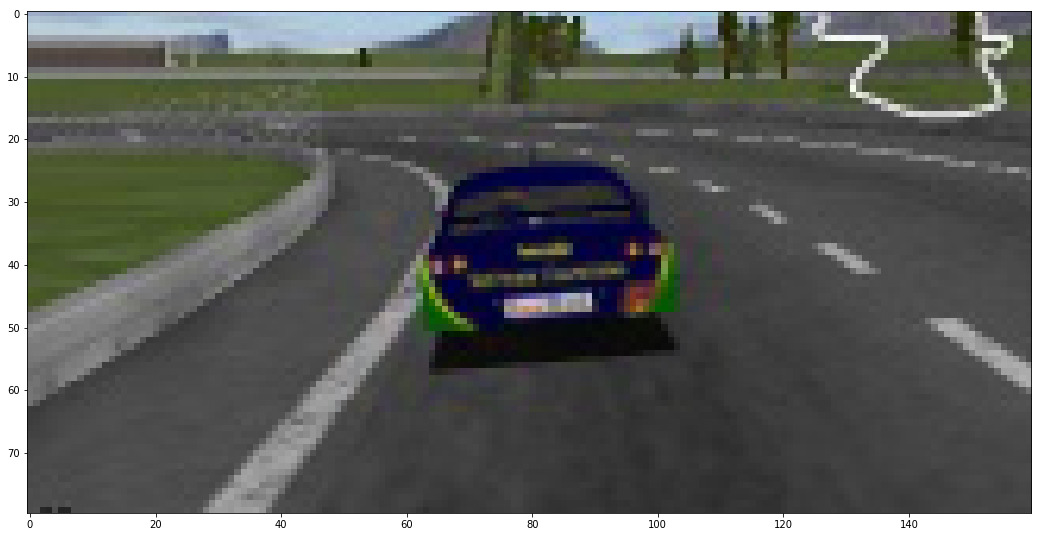

In [6]:
plt.figure(num=3, figsize=(18, 15),)
a = im_read(file_list[0])
a = cv2.resize(a,(160,80))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
a = np.reshape(a , (1,) + a.shape)
#a = a/127.5 - 1.
plt.imshow(a[0])

In [7]:
src_img = np.asarray([   cv2.resize(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB),(160,80))/127.5 - 1.  for i in file_list])


## load  model

####  设置环境变量，设置tf参数
#### 如果不启动tf session ，不用设置config

In [8]:
ckpt = tf.train.latest_checkpoint(log_dir)
model_path = ckpt+'.meta'

In [9]:
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True

In [10]:
tf.reset_default_graph()

with tf.Session(config=config) as sess:

    # Restore graph
    saver = tf.train.import_meta_graph(model_path)

    saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/log7/model.ckpt-1015936


In [11]:
sess = tf.Session(config=config)
saver = tf.train.import_meta_graph(model_path)
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/log7/model.ckpt-1015936


In [12]:
ls /home/sdc/github/AdversarialVariationalBayes/

avb/          img/        README.md      run_iaf.py  tools/
datasets/     LICENSE     run_auxvae.py  run_vae.py
experiments/  notebooks/  run_avae.py    test.py


In [13]:
from avb import inputs
from avb.decoders import get_decoder
from avb.avb.models import get_encoder, get_adversary
from avb.avb import AVB

/home/sdc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [14]:
avb_config = {}
avb_config['gf_dim'] = 64
avb_config['df_dim'] = 64
avb_config['test_is_adaptive_eps'] = False
avb_config['dataset'] = 'torcs'
avb_config['encoder']= 'conv2'
avb_config['decoder']='conv2'
avb_config['adversary']='conv1'
avb_config['image-size']=128
avb_config['output-size']= 64
avb_config['c_dim']= 3
avb_config['z_dim']= 64
avb_config['z_dist']='gauss'
avb_config['cond_dist']= 'gauss'
avb_config['eps_dim'] = 0
avb_config['eps_nbasis']= 32
avb_config['is_ac'] = False
avb_config['output_size'] = 64

In [15]:
decoder = get_decoder(avb_config['decoder'], avb_config) #conv2
encoder = get_encoder(avb_config['encoder'], avb_config) #conv2
adversary = get_adversary(avb_config['adversary'], avb_config) #conv1

In [16]:
x_train = tf.placeholder(shape=[64,128,128,3],dtype=tf.float32)
z_sampled = tf.random_normal([64, 64])

In [17]:
avb_train = AVB(encoder, decoder, adversary, x_train, z_sampled, avb_config, beta=1)

ValueError: Dimensions must be equal, but are 128 and 64 for 'sub_15' (op: 'Sub') with input shapes: [64,128,128,3], [?,64,64,3].

In [ ]:
avb_train.decoder_out[0]

In [ ]:
avb_train.z_real

In [ ]:
feed_dict = {x_train : np.random.randn(64,128,128,3) }
sess.run(tf.global_variables_initializer())
sess.run(avb_train.z_real,feed_dict= feed_dict)

In [ ]:
class Predictor():
    def __init__(self,sess,output_names,input_names):
        assert output_name is list , input_names is list
        self.sess = sess
        self.outputs = [sess.graph.get_tensor_by_name(i) for i in output_names]
        self.inputs = [sess.graph.get_tensor_by_name(i) for i in input_names]
    def predict(self ,data):
        assert data is list 
        assert len(data) == len(self.feed_dict)
        feed_dict = {i:j for i,j in zip(self.inputs ,data) }
        outputs = self.sess.run(self.outputs , feed_dict = feed_dict )

In [ ]:
#inputs_tensor_names = []
#outputs_tensor_names = []

#predictor = Predictor(sess , )

### load keras model

In [ ]:
from keras.models import load_model
from keras import backend as K
K.set_session(sess)

In [ ]:
#sys.path.append('../research')

In [ ]:
from models.autoencoder import generator , encoder ,get_model 
from models.interpolate import slerp

In [ ]:
image_shape=(80, 160, 3)
gf_dim=64
df_dim=64
batch_size=64
ch = image_shape[2]
rows = [int(image_shape[0] / i) for i in [16, 8, 4, 2, 1]]
cols = [int(image_shape[1] / i) for i in [16, 8, 4, 2, 1]]
G = generator(None, gf_dim, ch, rows, cols)
E = encoder(None, df_dim, ch, rows, cols)
weights_path = lambda x : 'outputs/results_autoencoder/{}_weights.keras'.format(x)
G.load_weights(weights_path('G'))
E.load_weights(weights_path('E'))

###### 必须设置 K.learning_phase()
启动batchnorma层

K.set_learning_phase(value=1) 将会把K.learning_phase() 设置为整数1，无法feed_dict赋值

### encoder

In [ ]:
model = E
get_E_output = K.function([model.input, K.learning_phase()],
                                  model.outputs)
# output in train mode = 1
def E_predict(x):
    return get_E_output([x, 1])

In [ ]:
E_output_1 = E_predict(src_img)

In [ ]:
E_output_1[0][0][0]

###### samplle a latant tensor

In [ ]:
z1 = E_output_1[0] + np.random.normal(0.,1,E_output_1[0].shape)*E_output_1[1]

In [ ]:
z1.shape,z1[:1].shape

In [ ]:
def get_slerp(codes, N = 20, z_dim = 512):
    shape = codes.shape
    code_a = codes[:int(shape[0] / 2)]
    code_a = np.reshape(code_a, [-1,  z_dim])
    code_b = codes[int(shape[0] / 2):]
    code_b = np.reshape(code_b, [-1,  z_dim])
    z_inter = []
    for low ,high in zip(code_a , code_b):
        for alpha in np.linspace(0., 1., N):
            interp_point = slerp(alpha, low , high)
            z_inter.append(interp_point)
    z_inter = np.asarray(z_inter)
    z_inter = np.reshape(z_inter, [-1, z_dim])
    return z_inter

In [ ]:
z_inter = get_slerp(z1 ,)

In [ ]:
z_inter.shape

### generator

In [ ]:
model = G
get_G_output = K.function([model.input, K.learning_phase()],
                                  model.outputs)

def G_predict(z):
    return get_G_output([z, 1])

In [ ]:
G_output = G_predict(z_inter)

### 生成图像

In [ ]:
plt.imshow(G_output[0][0])

In [ ]:
def cvt_imgs(decode_img ,src_img=None):

    size = decode_img.shape[0]
    N = int(size/8 +2)
    big_img = np.ones([80*8, 160*N, 3], np.float32)
    img_list = [None]*8*N
    for i in list(range(8)):
        img_list[N * i ] = src_img[i+8]
        img_list[N * i  + N - 1] = src_img[i ]

    index = 0
    for i in range(len(img_list)):
        if img_list[i] is   None:
            img_list[i] = decode_img[index][:]
            index +=1
    o_shape = [80,160]
    for i in range(8):
        for j in range(N):
            addimg = img_list[i * N + j][:]
            big_img[i * o_shape[0]:(i + 1) * o_shape[0], j * o_shape[1]:(j + 1) * o_shape[1]] = addimg
    big_img = (big_img + 1.)*255./2.
    big_img_rgb = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)
    return big_img_rgb

In [ ]:
big_img = cvt_imgs(G_output[0] , src_img )
cv2.imwrite('inference/{}.jpg'.format(int(time.time())),big_img)

# interplate

In [ ]:
img = src_img[14:15]
#plt.imshow(f(img[0])[:,:,::-1])

In [ ]:
s = lambda x : x[0] + np.random.normal(0.,1,x[0].shape)*x[1]
f = lambda x : x/2. + 0.5


In [ ]:
def change(x, index = 0 , range_ = (0,1), n = 5):
    n = int(n)
    #print(n)
    x = np.repeat(x, n, 0)
    #print(x.shape)
    x[:,index] = x[:,index]+np.linspace(range_[0],range_[1],n)
    return x

In [ ]:
def interp(img,**kwargs):
    code = E_predict(img)
    code = s(code)
    code = change(code,**kwargs)
    gen = G_predict(code)[0]
    gen = f(gen)
    return gen

### final

In [ ]:
gen = interp(img,index =24, range_ = (-3,3) , n=20)
plt.figure(num=3, figsize=(48, 75),)
for i in range(len(gen)):
    plt.subplot(15,5,i+1)
    plt.imshow(gen[i])

### divide

In [54]:
resize = lambda x :cv2.resize(x , (160,80))
l_img = resize(cv2.imread('l.jpg'))
r_img = resize(cv2.imread('r.jpg'))

In [55]:
img = np.asarray([l_img,r_img])

In [56]:
for i in range(50):
    code = E_predict(img)
    code = s(code)
    v = code[0] - code[1]
    print(v.argmax())

196
495
380
196
351
380
351
214
214
214
196
380
214
214
254
196
214
196
389
214
196
380
380
196
196
380
196
214
254
196
214
214
351
373
196
196
196
351
196
351
196
196
196
196
196
351
380
389
196
214
